In [1]:
%matplotlib inline


# Fitting an image and points

In this example, we will fit a cross onto the same cross, but rotated. We will take advantage of this knowledge and use a rotation deformation module. We will also add some noise on the initial center guess to show how to fit the geometrical descriptors. In addition to images, we add points at the extremity of each branch that will also get matched in order to illustrate multi deformables matching. This also helps the fitting process by adding more information to the model.




Import relevant modules.




In [2]:
import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage

import imodal

imodal.Utilities.set_compute_backend('torch')

Load image data and generate dots.




In [3]:
source_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+_30.png", origin='lower')
target_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+.png", origin='lower')

# Smoothing
sig_smooth = 0.
source_image = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
target_image = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

extent_length = 31.
extent = imodal.Utilities.AABB(0., extent_length, 0., extent_length)

center = extent_length*torch.tensor([[0.3, 0.1]])
print(center)
#center = extent_length*torch.tensor([[0.5, 0.5]])

tensor([[9.3000, 3.1000]])


Plot everything.




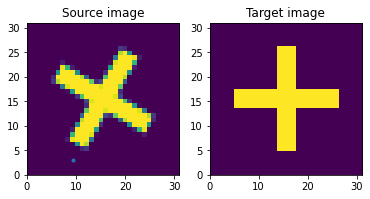

In [4]:
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[:, 0], center.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, origin='lower', extent=extent.totuple())

plt.show()

We know that the target cross is the result of some rotation at its origin,
so we use a local rotation deformation module, with an imprecise center
position to simulate data aquisition noise.




In [5]:
rotation = imodal.DeformationModules.LocalRotation(2, 2.*extent_length, gd=center)

Create the model by setting `True` for `fit_gd` so that it also optimize the
rotation center.




In [6]:
source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=False)
source_deformable2 = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=True)
target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=False)

attachment = imodal.Attachment.L2NormAttachment(transform=None)

model = imodal.Models.RegistrationModel([source_deformable, source_deformable2], [rotation], [attachment, attachment], fit_gd=[True], lam=1000.)

Fit the model.




In [7]:
shoot_solver = 'rk4'
shoot_it = 10
max_it = 100

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable, target_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS, using solver rk4 with 10 iterations.
Initial cost={'deformation': 0.0, 'attach': 396647.0}
1e-10
Evaluated model with costs=396647.0
Evaluated model with costs=393346.6080885427
Evaluated model with costs=391780.3756231442
Evaluated model with costs=373639.5272409916
Evaluated model with costs=323734.10282325745
Evaluated model with costs=488457.0319824219
Evaluated model with costs=273381.8834075928
Evaluated model with costs=269910.7558898926
Evaluated model with costs=269651.69456481934
Evaluated model with costs=269353.24479675293
Evaluated model with costs=268245.1169433594
Evaluated model with costs=264886.37327575684
Evaluated model with costs=260957.46774291992
Evaluated model with costs=266821.5690765381
Evaluated model with costs=246672.01768493652
Evaluated model with costs=231096.31871032715
Evaluated model with costs=353250.1518301964
Evaluated model with costs=218551.45790100098
Evaluated model with costs=260482.3228149414
Ev

Compute the final deformed source and plot it.




(0.0, 31.0, 0.0, 31.0)

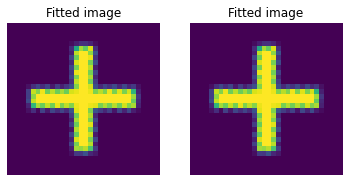

In [8]:
intermediates = {}
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

    deformed_image = deformed[0][0].view_as(source_image)

    deformed_image2 = deformed[1][0].view_as(source_image)

plt.subplot(1, 2, 1)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Fitted image")
plt.imshow(deformed_image2.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')

(0.0, 31.0, 0.0, 31.0)

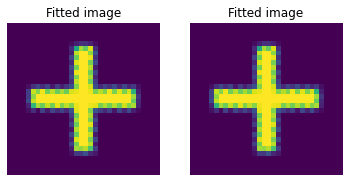

In [9]:
intermediates = {}
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

    deformed_image = deformed[0][0].view_as(source_image)

    deformed_image2 = deformed[1][0].view_as(source_image)

plt.subplot(1, 2, 1)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Fitted image")
plt.imshow(deformed_image2.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')

Fitted rotatation center: [[15.523167610168457, 15.47747802734375]]


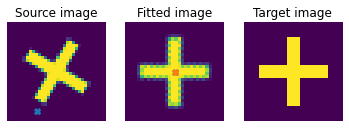

In [8]:
intermediates = {}
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

    deformed_image = deformed[0][0].view_as(source_image)

    deformed_image2 = deformed[1][0].view_as(source_image)

fitted_center = model.init_manifold[1].gd.detach()
fitted_center_final = intermediates['states'][-1][1].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.plot(fitted_center_final.numpy()[0, 0], fitted_center_final.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')

plt.show()

In [9]:
model.deformables = [source_deformable]

AttributeError: can't set attribute